In [3]:
!pip install tensorflow-datasets


import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   --------- ------------------------------ 1.3/5.3 MB 5.6 MB/s eta 0:00:01
   ----------------------- ---------------- 3.1/5.3 MB 6.1 MB/s eta 0:00:01
   ----------------------------- ---------- 3.9/5.3 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------  5.2/5.3 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 5.5 MB/s  0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21644 sha256=b685a1b386718114840332f87b7b59e8497fc9262bc2d7a1f38351b2f773c429
  Sto

In [5]:
# ================== DATA PREPARATION ==================
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load tf_flowers dataset
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Gayatri\tensorflow_datasets\tf_flowers\incomplete.IP5IOU_3.0.1\tf_flowers-train.tfrecord*..…

Dataset tf_flowers downloaded and prepared to C:\Users\Gayatri\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [7]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)

class_names = ds_info.features['label'].names

In [9]:
# ================== MODEL DEFINITION ==================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Feature extraction mode

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
# ================== TRAINING (Feature Extraction) ==================
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Training MobileNetV2 (Feature Extraction) ---")
history = model.fit(train_ds, validation_data=val_ds, epochs=3)


--- Training MobileNetV2 (Feature Extraction) ---
Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.7337 - loss: 0.7361 - val_accuracy: 0.8436 - val_loss: 0.4487
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.8747 - loss: 0.3712 - val_accuracy: 0.8618 - val_loss: 0.3667
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.9029 - loss: 0.2959 - val_accuracy: 0.8873 - val_loss: 0.3211


In [13]:
# ================== FINE-TUNING ==================
print("\n--- Fine-tuning MobileNetV2 ---")
base_model.trainable = True

# Optionally freeze most layers (fine-tune only top ones)
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_ds, validation_data=val_ds, epochs=3)


--- Fine-tuning MobileNetV2 ---
Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 315ms/step - accuracy: 0.8494 - loss: 0.4430 - val_accuracy: 0.8818 - val_loss: 0.3085
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 315ms/step - accuracy: 0.8974 - loss: 0.3125 - val_accuracy: 0.8855 - val_loss: 0.2985
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 33s 332ms/step - accuracy: 0.9186 - loss: 0.2631 - val_accuracy: 0.8855 - val_loss: 0.2877


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.8855 - loss: 0.2877

✅ Validation Accuracy after Fine-tuning: 0.8855


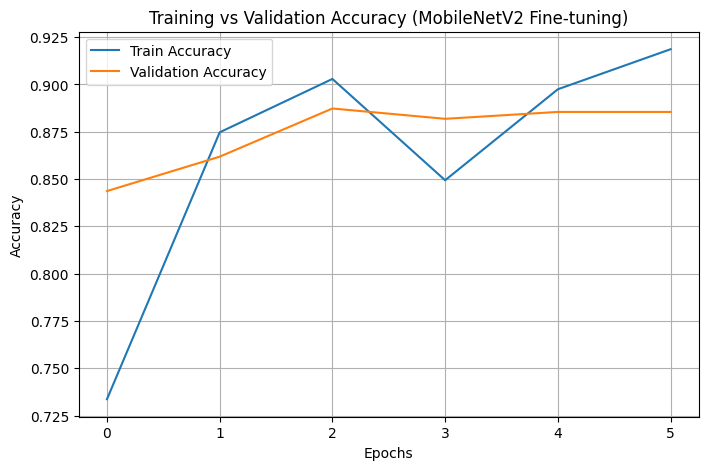

In [15]:
# ================== EVALUATION ==================
val_loss, val_acc = model.evaluate(val_ds)
print(f"\n✅ Validation Accuracy after Fine-tuning: {val_acc:.4f}")

# Accuracy plot
train_acc = history.history['accuracy'] + history_fine.history['accuracy']
val_accs = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title("Training vs Validation Accuracy (MobileNetV2 Fine-tuning)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


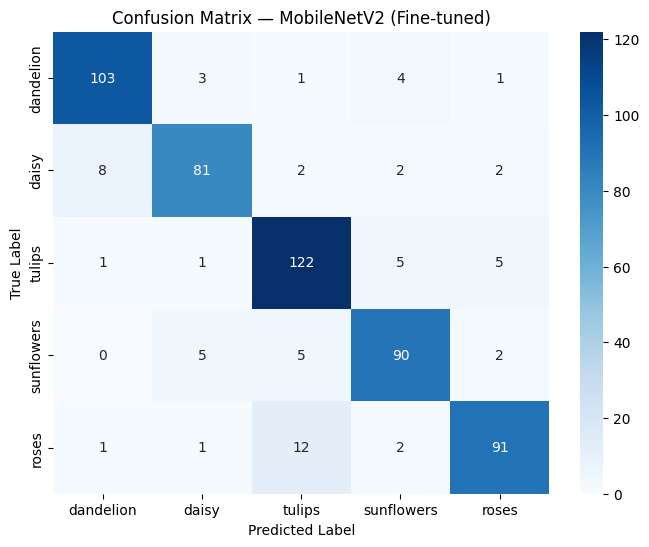


Classification Report:
              precision    recall  f1-score   support

   dandelion       0.91      0.92      0.92       112
       daisy       0.89      0.85      0.87        95
      tulips       0.86      0.91      0.88       134
  sunflowers       0.87      0.88      0.88       102
       roses       0.90      0.85      0.88       107

    accuracy                           0.89       550
   macro avg       0.89      0.88      0.88       550
weighted avg       0.89      0.89      0.89       550



In [17]:
# ================== CONFUSION MATRIX & REPORT ==================
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — MobileNetV2 (Fine-tuned)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [19]:
# ================== TEST ON CUSTOM IMAGES ==================
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

    preds = model.predict(img_array, verbose=0)
    pred_label = np.argmax(preds)
    confidence = preds[0][pred_label]

    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"Predicted: {class_names[pred_label]} (Confidence: {confidence:.2f})")

    plt.imshow(img)
    plt.title(f"{class_names[pred_label]} ({confidence:.2f})")
    plt.axis('off')
    plt.show()


Image: Daisy.webp
Predicted: daisy (Confidence: 1.00)


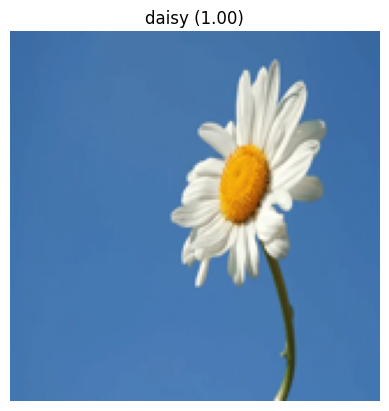


Image: Dandelion.webp
Predicted: dandelion (Confidence: 0.76)


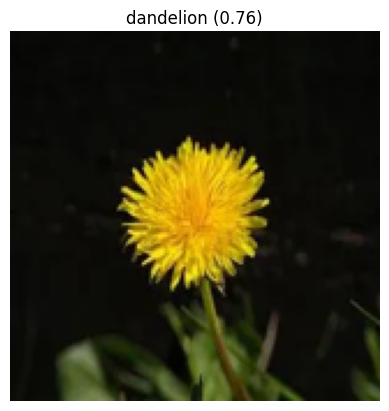


Image: Rose.webp
Predicted: roses (Confidence: 0.89)


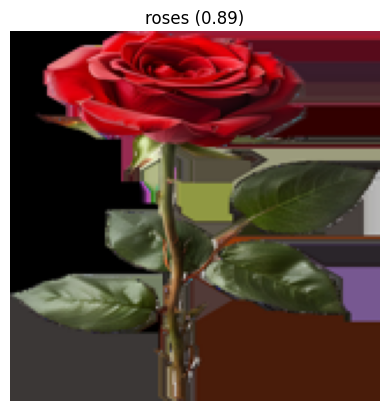


Image: Sunflower.webp
Predicted: sunflowers (Confidence: 0.99)


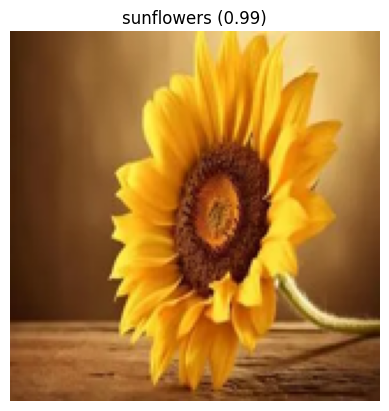


Image: Tulip.webp
Predicted: tulips (Confidence: 0.99)


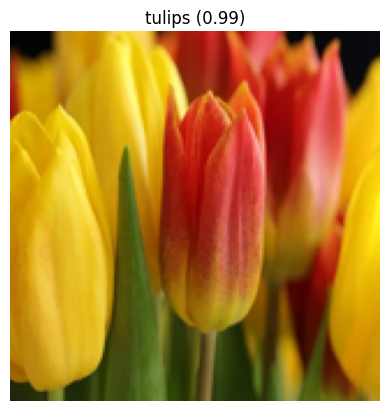

In [25]:
folder_path = r"D:\DEEP_LEARNING_Prac\Test Dataset"

# Get all image files in that folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

# Run prediction on each image
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    predict_image(image_path)